<a href="https://colab.research.google.com/github/ahatesham02/Bangla-Image-Captioning/blob/main/Few_shot%20Test1_learning_with_bornonImage_Captioning_with_Bahdanau_Attention_(Bidirectional_GRU)_Bancap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import string
import keras
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from keras.backend import set_session
import sys, time, os, warnings 
warnings.filterwarnings("ignore")
import re

import numpy as np
import pandas as pd 
from PIL import Image
import pickle
from collections import Counter
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint
from keras.utils import load_img, img_to_array
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip

!unzip -qq Flickr8k_Dataset.zip

In [ ]:
! pip install bnlp_toolkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 73.6 MB/s eta 0:00:00
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
import bnlp
from bnlp.corpus import  punctuations, letters, digits

punkt not found. downloading...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Thesis/Flicker8k Bangla/BAN-Cap_captiondata.csv')

FileNotFoundError: ignored

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data.head(15)

In [ ]:
def create_vocabulary(data):
  vocab = []
  for captions in data.bengali_caption.values:
    vocab.extend(captions.split())
  print("Vocabulary Size : {}".format(len(set(vocab))))
  return vocab

In [ ]:
vocabulary = create_vocabulary(data)

In [ ]:
table = str.maketrans('', '', punctuations)
desc = [w.translate(table) for w in data.bengali_caption]

In [ ]:
def cleaning(row):
  text = re.sub('[^\u0980-\u09FF]',' ', row) 
  return text

In [ ]:
data['bengali_caption'] = data.bengali_caption.apply(cleaning)

In [ ]:
data.head(10)

In [ ]:
clean_vocabulary = create_vocabulary(data)

In [4]:
from os import listdir
## The location of the Flickr8K_ photos
image_dir = '/content/Flicker8k_Dataset'
images = listdir(image_dir)

In [ ]:
def clean(col):
  text = col.split('#')[0]
  return text
  
  

In [ ]:
data2 = data.copy()

In [ ]:
data2.head(10)

In [ ]:
data2['caption_id'] = data2.caption_id.apply(lambda x : x.split('#')[0])

In [ ]:
data2.head(10)

In [ ]:
data[7000:7010]

In [ ]:
data2.shape

In [ ]:
data3 = data2[:40000]

In [ ]:
data3.shape

In [ ]:
def preprocess_images(data):
  img_name_vector = []

  for filenames in data3["caption_id"]:
      full_image_path = image_dir+"/"+ filenames
      img_name_vector.append(full_image_path)
  return img_name_vector
img_name_vector = preprocess_images(data)
img_name_vector[:10]

In [ ]:
def preprocess_captions(data):
  total_captions = []

  for caption  in data3["bengali_caption"].astype(str):
      caption = '<start> ' + caption+ ' <end>'
      total_captions.append(caption)
  return total_captions
total_captions = preprocess_captions(data)
total_captions[:10]

In [ ]:
"""def data_limiter(num,total_captions,img_name_vector):
  # Shuffle captions and image_names together
  train_captions, img_name_vector = shuffle(total_captions,img_name_vector,random_state=1)
  train_captions = train_captions[:num]
  img_name_vector = img_name_vector[:num]
  return train_captions,img_name_vector"""

In [ ]:
#total_captions,img_name_vector = data_limiter(40000,total_captions,img_name_vector)

In [ ]:
len(total_captions)

In [ ]:
from pickle import dump

# save to file
dump(total_captions, open('bengali_captions.pkl', 'wb'))
dump(img_name_vector, open('bengali_img_names.pkl', 'wb'))

In [ ]:
from pickle import load

In [5]:
total_captions = load(open('/content/drive/MyDrive/NLP dataset/Bancap/bancap_captions.pkl', 'rb'))
img_name_vector = load(open('/content/drive/MyDrive/NLP dataset/Bancap/bancap_img_names.pkl', 'rb'))

In [6]:
len(img_name_vector)

40000

##Bornon Dataset

In [7]:
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

In [8]:
import zipfile
exfile= '/content/drive/MyDrive/NLP dataset/Bornon/Bornon Images-20221222T175856Z-001.zip'
zip_ref = zipfile.ZipFile(exfile, 'r')
zip_ref.extractall()
zip_ref.close()

In [9]:
from os import listdir
## The location of the Flickr8K_ photos
image_dir = '/content/Bornon Images'
images = listdir(image_dir)

## The location of the caption file
descriptions_dir = '/content/drive/MyDrive/Thesis/Bornon/bornon_train_token.txt'
print("The number of jpg flies in Bornon: {}".format(len(images)))

The number of jpg flies in Bornon: 4106


## Bancap + Bornon (1000)

In [10]:
train_captions_bornon = load(open('/content/drive/MyDrive/NLP dataset/Bornon/bornon_captions.pkl', 'rb'))
img_name_vector_bornon = load(open('/content/drive/MyDrive/NLP dataset/Bornon/bornon_img_names.pkl', 'rb'))

In [11]:
len(img_name_vector_bornon)

20439

In [12]:
bornon_train, bornon_test, bornon_cap_train, bornon_cap_test = train_test_split(img_name_vector_bornon, train_captions_bornon, test_size = 0.1, random_state = 42)

In [13]:
len(bornon_train)

18395

In [14]:
len(bornon_train[:(len(bornon_train))//4])

4598

In [15]:
train_captions1 = total_captions[:35000] + bornon_cap_train[:(len(bornon_train))//4]
img_name_vector1 = img_name_vector[:35000] + bornon_train[:(len(bornon_train))//4]

In [16]:
# To know the shape of images
def img_shape_finder(image):
  img= plt.imread(image)

  print("Shape of the image ==> {0} is ==> {1}".format(image.split('/')[1],img.shape))

In [17]:
img_list=[]
for i in range(20):
  img_list.append(img_name_vector[i])

In [18]:
for j in img_list:
  img_shape_finder(j)

Shape of the image ==> content is ==> (500, 375, 3)
Shape of the image ==> content is ==> (500, 375, 3)
Shape of the image ==> content is ==> (500, 375, 3)
Shape of the image ==> content is ==> (500, 375, 3)
Shape of the image ==> content is ==> (500, 375, 3)
Shape of the image ==> content is ==> (375, 500, 3)
Shape of the image ==> content is ==> (375, 500, 3)
Shape of the image ==> content is ==> (375, 500, 3)
Shape of the image ==> content is ==> (375, 500, 3)
Shape of the image ==> content is ==> (375, 500, 3)
Shape of the image ==> content is ==> (400, 500, 3)
Shape of the image ==> content is ==> (400, 500, 3)
Shape of the image ==> content is ==> (400, 500, 3)
Shape of the image ==> content is ==> (400, 500, 3)
Shape of the image ==> content is ==> (400, 500, 3)
Shape of the image ==> content is ==> (410, 500, 3)
Shape of the image ==> content is ==> (410, 500, 3)
Shape of the image ==> content is ==> (410, 500, 3)
Shape of the image ==> content is ==> (410, 500, 3)
Shape of the

In [19]:
import tensorflow as tf

In [20]:
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input

In [21]:
image_model = ResNet50(include_top=False,weights='imagenet')
new_input = image_model.input 
hidden_layer = image_model.layers[-1].output  
image_features_extract_model = tf.compat.v1.keras.Model(new_input, hidden_layer)

94765736/94765736 [==============================] - 0s 0us/step


In [22]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

In [23]:
preprocessed_image = []
IMAGE_SHAPE = (224, 224)

In [24]:
for img in img_name_vector1[0:5] :
    img = tf.io.read_file(img, name=None)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.resnet50.preprocess_input(img)
    preprocessed_image.append(img)

Shape after resize :  (224, 224, 3)
Shape after resize :  (224, 224, 3)
Shape after resize :  (224, 224, 3)
Shape after resize :  (224, 224, 3)
Shape after resize :  (224, 224, 3)


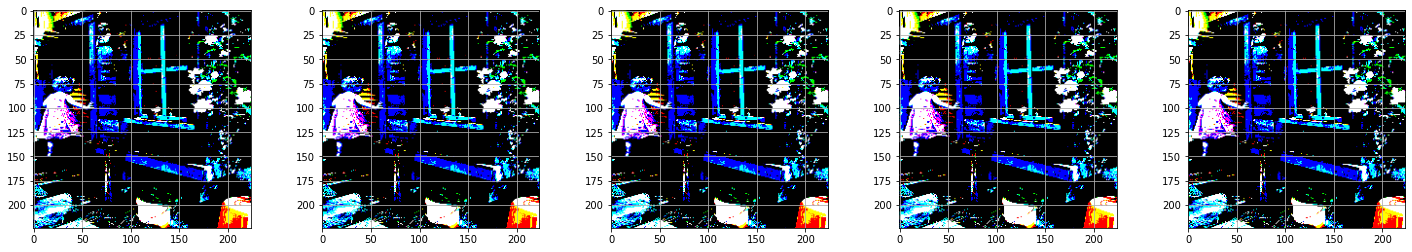

In [25]:
# checking first five images post preprocessing
Display_Images = preprocessed_image[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(25)
for ax, image in zip(axes, Display_Images) :
  print('Shape after resize : ', image.shape)
  ax.imshow(image)
  ax.grid('off')

Shape after resize : (224, 224, 3)


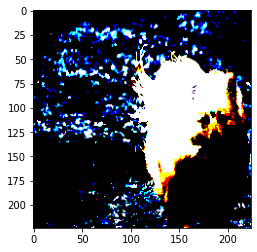

In [26]:
def load_images(image_path) :
  img = tf.io.read_file(image_path, name = None)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, IMAGE_SHAPE)
  img = tf.keras.applications.resnet50.preprocess_input(img)
  return img, image_path

img1,img1_path = load_images("Flicker8k_Dataset/3439243433_d5f3508612.jpg")
print("Shape after resize :", img1.shape)
plt.imshow(img1)

In [27]:

tokenizer = tf.keras.preprocessing.text.Tokenizer(
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(train_captions1)
train_seqs = tokenizer.texts_to_sequences(train_captions1)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions1)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [28]:
vocab_size = len(tokenizer.index_word)+1

In [29]:
vocab_size

15608

In [30]:
train_captions1[:3]

['<start> একটি গোলাপী জামা পরা বাচ্চা মেয়ে একটি বাড়ির প্রবেশ পথের সিঁড়ি বেয়ে উঠছে  <end>',
 '<start> একটি মেয়ে শিশু একটি কাঠের বাড়িতে ঢুকছে <end>',
 '<start> একটি বাচ্চা তার কাঠের খেলাঘরে উঠছে   <end>']

In [31]:
train_seqs[:3]

[[2, 4, 205, 44, 21, 36, 47, 4, 1044, 1271, 851, 1015, 174, 148, 3],
 [2, 4, 47, 46, 4, 136, 7738, 3396, 3],
 [2, 4, 36, 20, 136, 3873, 148, 3]]

In [32]:
tokenizer.index_word

{1: '<unk>',
 2: '<start>',
 3: '<end>',
 4: 'একটি',
 5: 'একজন',
 6: 'আছে',
 7: 'কুকুর',
 8: 'লোক',
 9: 'এক',
 10: 'করছে',
 11: 'এবং',
 12: 'সাদা',
 13: 'উপর',
 14: 'কালো',
 15: 'যাচ্ছে',
 16: 'বসে',
 17: 'মহিলা',
 18: 'দুটি',
 19: 'খেলছে',
 20: 'তার',
 21: 'পরা',
 22: 'ছেলে',
 23: 'লাল',
 24: 'দিয়ে',
 25: 'রঙের',
 26: 'ছোট',
 27: 'ও',
 28: 'নীল',
 29: 'পরিহিত',
 30: 'মধ্যে',
 31: 'দেখা',
 32: 'পাশে',
 33: 'দাঁড়িয়ে',
 34: 'নিয়ে',
 35: 'কিছু',
 36: 'বাচ্চা',
 37: 'ব্যক্তি',
 38: 'করে',
 39: 'লাফ',
 40: 'দৌড়াচ্ছে',
 41: 'দিচ্ছে',
 42: 'সামনে',
 43: 'দিকে',
 44: 'জামা',
 45: 'ধরে',
 46: 'শিশু',
 47: 'মেয়ে',
 48: 'পরে',
 49: 'থেকে',
 50: 'দিয়ে',
 51: 'দাঁড়িয়ে',
 52: 'কুকুরটি',
 53: 'ঘাসের',
 54: 'বল',
 55: 'সাথে',
 56: 'বাদামী',
 57: 'পানিতে',
 58: 'নিয়ে',
 59: 'সবুজ',
 60: 'মানুষ',
 61: 'জন্য',
 62: 'হলুদ',
 63: 'একদল',
 64: 'মেয়ে',
 65: 'মাঠে',
 66: 'দুই',
 67: 'ছবি',
 68: 'পোশাক',
 69: 'দুজন',
 70: 'মুখে',
 71: 'লোকটি',
 72: 'আছেন',
 73: 'সাইকেল',
 74: 'হাতে',
 75: 'বালক',
 76: 'দে

In [33]:
# Pad each vector to the max_length of the captions  store it to a vairable

train_seqs_len = [len(seq) for seq in train_seqs]

longest_word_length = max(train_seqs_len)

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding= 'post', maxlen = longest_word_length,
                                                          dtype='int32', value=0)
print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(39598, 34)


In [34]:
cap_vector

array([[   2,    4,  205, ...,    0,    0,    0],
       [   2,    4,   47, ...,    0,    0,    0],
       [   2,    4,   36, ...,    0,    0,    0],
       ...,
       [   2, 2021, 1143, ...,    0,    0,    0],
       [   2,   28,  355, ...,    0,    0,    0],
       [   2,    4, 1234, ...,    0,    0,    0]], dtype=int32)

In [35]:
len(cap_vector)

39598

In [36]:
len(img_name_vector1)

39598

In [37]:
# Map each image full path to the function, in order to preprocess the image
training_list = sorted(set(img_name_vector1))
New_Img = tf.data.Dataset.from_tensor_slices(training_list)
New_Img = New_Img.map(load_images, num_parallel_calls = tf.data.experimental.AUTOTUNE)
New_Img = New_Img.batch(64, drop_remainder=False)

In [38]:
path_train_shot1, path_test_shot1, caption_train_shot1, caption_test_shot1 = train_test_split(img_name_vector1, cap_vector, test_size = 0.1, random_state = 42)

In [39]:
from tqdm import tqdm

In [40]:
# extract features from each image in the dataset
img_features = {}
for image, image_path in tqdm(New_Img) :
  batch_features = image_features_extract_model(image)
  #squeeze out the features in a batch
  batch_features_flattened = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
  for batch_feat, path in zip(batch_features_flattened, image_path) :
    feature_path = path.numpy().decode('utf-8')
    img_features[feature_path] = batch_feat.numpy()

100%|██████████| 156/156 [00:58<00:00,  2.66it/s]


In [41]:
batch_features.shape

TensorShape([8, 7, 7, 2048])

In [42]:
len(img_features)

9928

In [43]:
#to provide, both images along with the captions as input
def map(image_name, caption):
    img_tensor = img_features[image_name.decode('utf-8')]
    return img_tensor, caption

In [44]:
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
BUFFER_SIZE = 1000
BATCH_SIZE = 64
def gen_dataset(img, capt):
        
    data = tf.data.Dataset.from_tensor_slices((img, capt))
    data = data.map(lambda ele1, ele2 : tf.numpy_function(map, [ele1, ele2], [tf.float32, tf.int32]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE)
    
     
    data = (data.shuffle(BUFFER_SIZE, reshuffle_each_iteration= True).batch(BATCH_SIZE, drop_remainder = False)
    .prefetch(tf.data.experimental.AUTOTUNE))
    return data

In [45]:
train_dataset = gen_dataset(path_train_shot1,caption_train_shot1)
test_dataset = gen_dataset(path_test_shot1,caption_test_shot1)

In [46]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 49, 2048)
(64, 34)


In [47]:
embedding_dim = 256
units = 512
vocab_size = vocab_size
train_num_steps = len(path_train_shot1) // BATCH_SIZE 
test_num_steps = len(path_test_shot1) // BATCH_SIZE 
EPOCHS = 20
max_length = 34
feature_shape = batch_feat.shape[1]
attention_feature_shape = batch_feat.shape[0]

In [48]:
from keras.utils.vis_utils import plot_model

tf.compat.v1.reset_default_graph()
print(tf.compat.v1.get_default_graph())

In [49]:
#Building Encoder using CNN Keras subclassing method

class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim) #build your Dense layer with relu activation
        
    def call(self, features):
        features =  self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0)
        return features

In [50]:
encoder=Encoder(embedding_dim)

In [51]:
class Bahdanau_Attention(Model):
    def __init__(self, units):
        super(Bahdanau_Attention, self).__init__()
        self.units=units
        self.W1 = tf.keras.layers.Dense(units) 
        self.W2 = tf.keras.layers.Dense(units) 
        self.V = tf.keras.layers.Dense(1) 
        

    def call(self, features, hidden):
        hidden_with_time_axis = hidden[:, tf.newaxis]
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))  
        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1) 
        context_vector = attention_weights * features 
        context_vector = tf.reduce_sum(context_vector, axis=1)  
        return context_vector, attention_weights

In [52]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Bahdanau_Attention(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform'))
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state_f,state_b = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        #print(output.shape)
        #print(state_f.shape)
        #print(state_b.shape)
        state = tf.keras.layers.Add()([state_f, state_b])
        #print(state.shape)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [53]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [54]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim

Feature shape from Encoder: (64, 49, 256)
Predcitions shape from Decoder: (64, 15608)
Attention weights shape from Decoder: (64, 49, 1)


In [55]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)  #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE)

In [56]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    #loss is getting multiplied with mask to get an ideal shape
    
    return tf.reduce_mean(loss_)

In [57]:
checkpoint_path = "/content/drive/MyDrive/NLP dataset/Bancap + Bornon/Few shot test"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [58]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [59]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        
        encoder_op = encoder(img_tensor)
        for r in range(1, target.shape[1]) :
          predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
          loss = loss + loss_function(target[:, r], predictions) 
          dec_input = tf.expand_dims(target[:, r], 1)  

    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars) 
    optimizer.apply_gradients(zip(grad, trainable_vars))

    return loss, avg_loss

In [60]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size = target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
      encoder_op = encoder(img_tensor)
      for r in range(1, target.shape[1]) :
        predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
        loss = loss + loss_function(target[:, r], predictions)
        dec_input = tf.expand_dims(target[: , r], 1)
    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars) 
    optimizer.apply_gradients(zip(grad, trainable_vars))                      
    return loss, avg_loss

In [61]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset) :
      batch_loss, t_loss = test_step(img_tensor, target)
      total_loss = total_loss + t_loss
      avg_test_loss = total_loss/ test_num_steps

    return avg_test_loss

In [62]:
loss_plot = []
test_loss_plot = []
EPOCHS = 30
best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps   
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/30 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.397, & test loss is 1.205
Time taken for 1 epoch 288.02868461608887 sec

Test loss has been reduced from 100.000 to 1.205


  3%|▎         | 1/30 [04:49<2:19:54, 289.47s/it]

For epoch: 2, the train loss is 1.082, & test loss is 1.035
Time taken for 1 epoch 98.5592155456543 sec

Test loss has been reduced from 1.205 to 1.035


  7%|▋         | 2/30 [06:29<1:23:00, 177.88s/it]

For epoch: 3, the train loss is 0.954, & test loss is 0.917
Time taken for 1 epoch 98.21842241287231 sec

Test loss has been reduced from 1.035 to 0.917


 10%|█         | 3/30 [08:08<1:03:53, 141.98s/it]

For epoch: 4, the train loss is 0.853, & test loss is 0.819
Time taken for 1 epoch 98.38398289680481 sec

Test loss has been reduced from 0.917 to 0.819


 13%|█▎        | 4/30 [09:48<54:16, 125.23s/it]  

For epoch: 5, the train loss is 0.767, & test loss is 0.737
Time taken for 1 epoch 98.28515982627869 sec

Test loss has been reduced from 0.819 to 0.737


 17%|█▋        | 5/30 [11:27<48:17, 115.90s/it]

For epoch: 6, the train loss is 0.695, & test loss is 0.668
Time taken for 1 epoch 98.30512976646423 sec

Test loss has been reduced from 0.737 to 0.668


 20%|██        | 6/30 [13:06<44:05, 110.24s/it]

For epoch: 7, the train loss is 0.631, & test loss is 0.604
Time taken for 1 epoch 98.50310754776001 sec

Test loss has been reduced from 0.668 to 0.604


 23%|██▎       | 7/30 [14:46<40:53, 106.69s/it]

For epoch: 8, the train loss is 0.573, & test loss is 0.546
Time taken for 1 epoch 98.51936745643616 sec

Test loss has been reduced from 0.604 to 0.546


 27%|██▋       | 8/30 [16:25<38:16, 104.41s/it]

For epoch: 9, the train loss is 0.527, & test loss is 0.497
Time taken for 1 epoch 98.49009704589844 sec

Test loss has been reduced from 0.546 to 0.497


 30%|███       | 9/30 [18:04<35:59, 102.84s/it]

For epoch: 10, the train loss is 0.475, & test loss is 0.447
Time taken for 1 epoch 98.43796443939209 sec

Test loss has been reduced from 0.497 to 0.447


 33%|███▎      | 10/30 [19:44<33:55, 101.80s/it]

For epoch: 11, the train loss is 0.429, & test loss is 0.404
Time taken for 1 epoch 98.51790189743042 sec

Test loss has been reduced from 0.447 to 0.404


 37%|███▋      | 11/30 [21:23<32:00, 101.09s/it]

For epoch: 12, the train loss is 0.389, & test loss is 0.365
Time taken for 1 epoch 98.43254446983337 sec

Test loss has been reduced from 0.404 to 0.365


 40%|████      | 12/30 [23:03<30:10, 100.56s/it]

For epoch: 13, the train loss is 0.356, & test loss is 0.341
Time taken for 1 epoch 98.49654650688171 sec

Test loss has been reduced from 0.365 to 0.341


 43%|████▎     | 13/30 [24:42<28:24, 100.29s/it]

For epoch: 14, the train loss is 0.326, & test loss is 0.304
Time taken for 1 epoch 98.25017762184143 sec

Test loss has been reduced from 0.341 to 0.304


 47%|████▋     | 14/30 [26:22<26:39, 99.99s/it] 

For epoch: 15, the train loss is 0.299, & test loss is 0.280
Time taken for 1 epoch 98.30277037620544 sec

Test loss has been reduced from 0.304 to 0.280


 50%|█████     | 15/30 [28:01<24:56, 99.79s/it]

For epoch: 16, the train loss is 0.272, & test loss is 0.257
Time taken for 1 epoch 98.38432621955872 sec

Test loss has been reduced from 0.280 to 0.257


 53%|█████▎    | 16/30 [29:40<23:15, 99.66s/it]

For epoch: 17, the train loss is 0.253, & test loss is 0.236
Time taken for 1 epoch 98.5804853439331 sec

Test loss has been reduced from 0.257 to 0.236


 57%|█████▋    | 17/30 [31:20<21:35, 99.62s/it]

For epoch: 18, the train loss is 0.234, & test loss is 0.224
Time taken for 1 epoch 98.36712598800659 sec

Test loss has been reduced from 0.236 to 0.224


 60%|██████    | 18/30 [32:59<19:54, 99.56s/it]

For epoch: 19, the train loss is 0.218, & test loss is 0.206
Time taken for 1 epoch 98.857346534729 sec

Test loss has been reduced from 0.224 to 0.206


 63%|██████▎   | 19/30 [34:39<18:16, 99.73s/it]

For epoch: 20, the train loss is 0.209, & test loss is 0.198
Time taken for 1 epoch 98.56712317466736 sec

Test loss has been reduced from 0.206 to 0.198


 70%|███████   | 21/30 [37:58<14:55, 99.46s/it]

For epoch: 21, the train loss is 0.196, & test loss is 0.205
Time taken for 1 epoch 98.28963255882263 sec

For epoch: 22, the train loss is 0.186, & test loss is 0.177
Time taken for 1 epoch 97.87583804130554 sec

Test loss has been reduced from 0.198 to 0.177


 77%|███████▋  | 23/30 [41:15<11:32, 98.96s/it]

For epoch: 23, the train loss is 0.181, & test loss is 0.178
Time taken for 1 epoch 98.24496245384216 sec

For epoch: 24, the train loss is 0.173, & test loss is 0.164
Time taken for 1 epoch 98.01137590408325 sec

Test loss has been reduced from 0.177 to 0.164


 80%|████████  | 24/30 [42:54<09:53, 98.94s/it]

For epoch: 25, the train loss is 0.163, & test loss is 0.156
Time taken for 1 epoch 98.24996542930603 sec

Test loss has been reduced from 0.164 to 0.156


 87%|████████▋ | 26/30 [46:12<06:35, 98.77s/it]

For epoch: 26, the train loss is 0.158, & test loss is 0.158
Time taken for 1 epoch 98.24750065803528 sec

For epoch: 27, the train loss is 0.153, & test loss is 0.151
Time taken for 1 epoch 98.0669903755188 sec

Test loss has been reduced from 0.156 to 0.151


 90%|█████████ | 27/30 [47:51<04:56, 98.83s/it]

For epoch: 28, the train loss is 0.149, & test loss is 0.139
Time taken for 1 epoch 98.30196332931519 sec

Test loss has been reduced from 0.151 to 0.139


 97%|█████████▋| 29/30 [51:08<01:38, 98.75s/it]

For epoch: 29, the train loss is 0.144, & test loss is 0.143
Time taken for 1 epoch 98.30809617042542 sec

For epoch: 30, the train loss is 0.143, & test loss is 0.139
Time taken for 1 epoch 98.14719557762146 sec

Test loss has been reduced from 0.139 to 0.139


100%|██████████| 30/30 [52:47<00:00, 105.59s/it]


In [63]:
ckpt_manager.checkpoints

['/content/drive/MyDrive/NLP dataset/Bancap + Bornon/Few shot test/ckpt-22',
 '/content/drive/MyDrive/NLP dataset/Bancap + Bornon/Few shot test/ckpt-23',
 '/content/drive/MyDrive/NLP dataset/Bancap + Bornon/Few shot test/ckpt-24',
 '/content/drive/MyDrive/NLP dataset/Bancap + Bornon/Few shot test/ckpt-25',
 '/content/drive/MyDrive/NLP dataset/Bancap + Bornon/Few shot test/ckpt-26']

In [65]:
ckpt.restore('/content/drive/MyDrive/NLP dataset/Bancap + Bornon/Few shot test/ckpt-26')

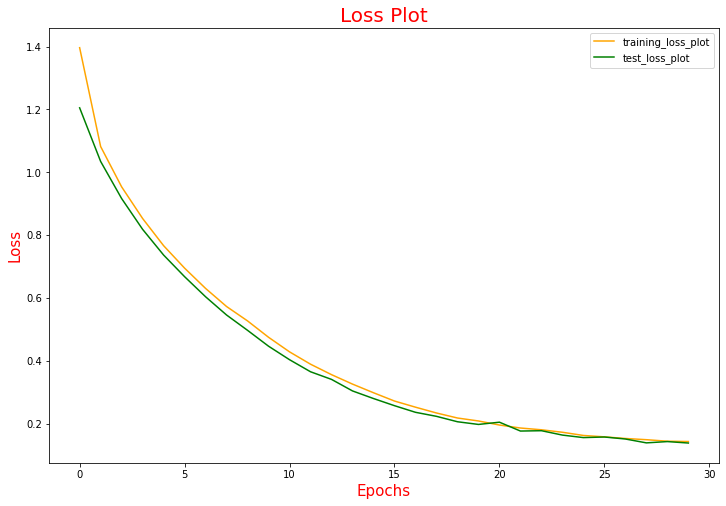

In [66]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8))
plt.plot(loss_plot, color='orange', label = 'training_loss_plot')
plt.plot(test_loss_plot, color='green', label = 'test_loss_plot')
plt.xlabel('Epochs', fontsize = 15, color = 'red')
plt.ylabel('Loss', fontsize = 15, color = 'red')
plt.title('Loss Plot', fontsize = 20, color = 'red')
plt.legend()
plt.show()

In [72]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_feature_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_images(image)[0], 0) 
    img_tensor_val = image_features_extract_model(temp_input) 
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder (img_tensor_val) 

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) 
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy() 
        result.append (tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

In [85]:
def plot_attention_map(caption, weights, image) :

  fig = plt.figure(figsize = (20, 20))
  temp_img = np.array(Image.open(image))

  cap_len = len(caption)
  for cap in range(len(caption)) :
    weights_img = np.reshape(weights[cap], (7,7))
    

    ax = fig.add_subplot(cap_len//2, cap_len//2, cap+1)
    ax.set_title(caption[cap])

    img = ax.imshow(temp_img)

    ax.imshow(weights_img, cmap='gray', alpha=0.6, extent=img.get_extent())
    ax.axis('off')
  plt.subplots_adjust(hspace=0.2, wspace=0.2)
  plt.show()

In [69]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

In [73]:
image_test = path_test_shot1.copy()

In [70]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [74]:
def pred_caption_audio(random, autoplay=False, weights=(0.5, 0.5, 0, 0)) :
    cap_test_data = caption_test_shot1.copy()
    rid = np.random.randint(0, len(path_test_shot1))
    test_image= path_test_shot1[rid]
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[rid] if i not in [0]])
    result, attention_plot, pred_test = evaluate(test_image)
    real_caption=filt_text(real_caption)      
    pred_caption=' '.join(result).rsplit(' ', 1)[0]
    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()
    score = sentence_bleu(reference, candidate, weights=weights)#set your weights
    print(f"BLEU score: {score*100}")
    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
    plot_attention_map(result, attention_plot, test_image)
    #speech = gTTS('Predicted Caption : ' + pred_caption, lang = 'bn', slow = False)
    #speech.save('voice.mp3')
    #audio_file = 'voice.mp3'
    #display.display(display.Audio(audio_file, rate = None, autoplay = autoplay))

    return test_image

BLEU score: 100.0
Real Caption: প্লেটটি দেখতে সাদা রঙের
Prediction Caption: প্লেটটি দেখতে সাদা রঙের


ValueError: ignored

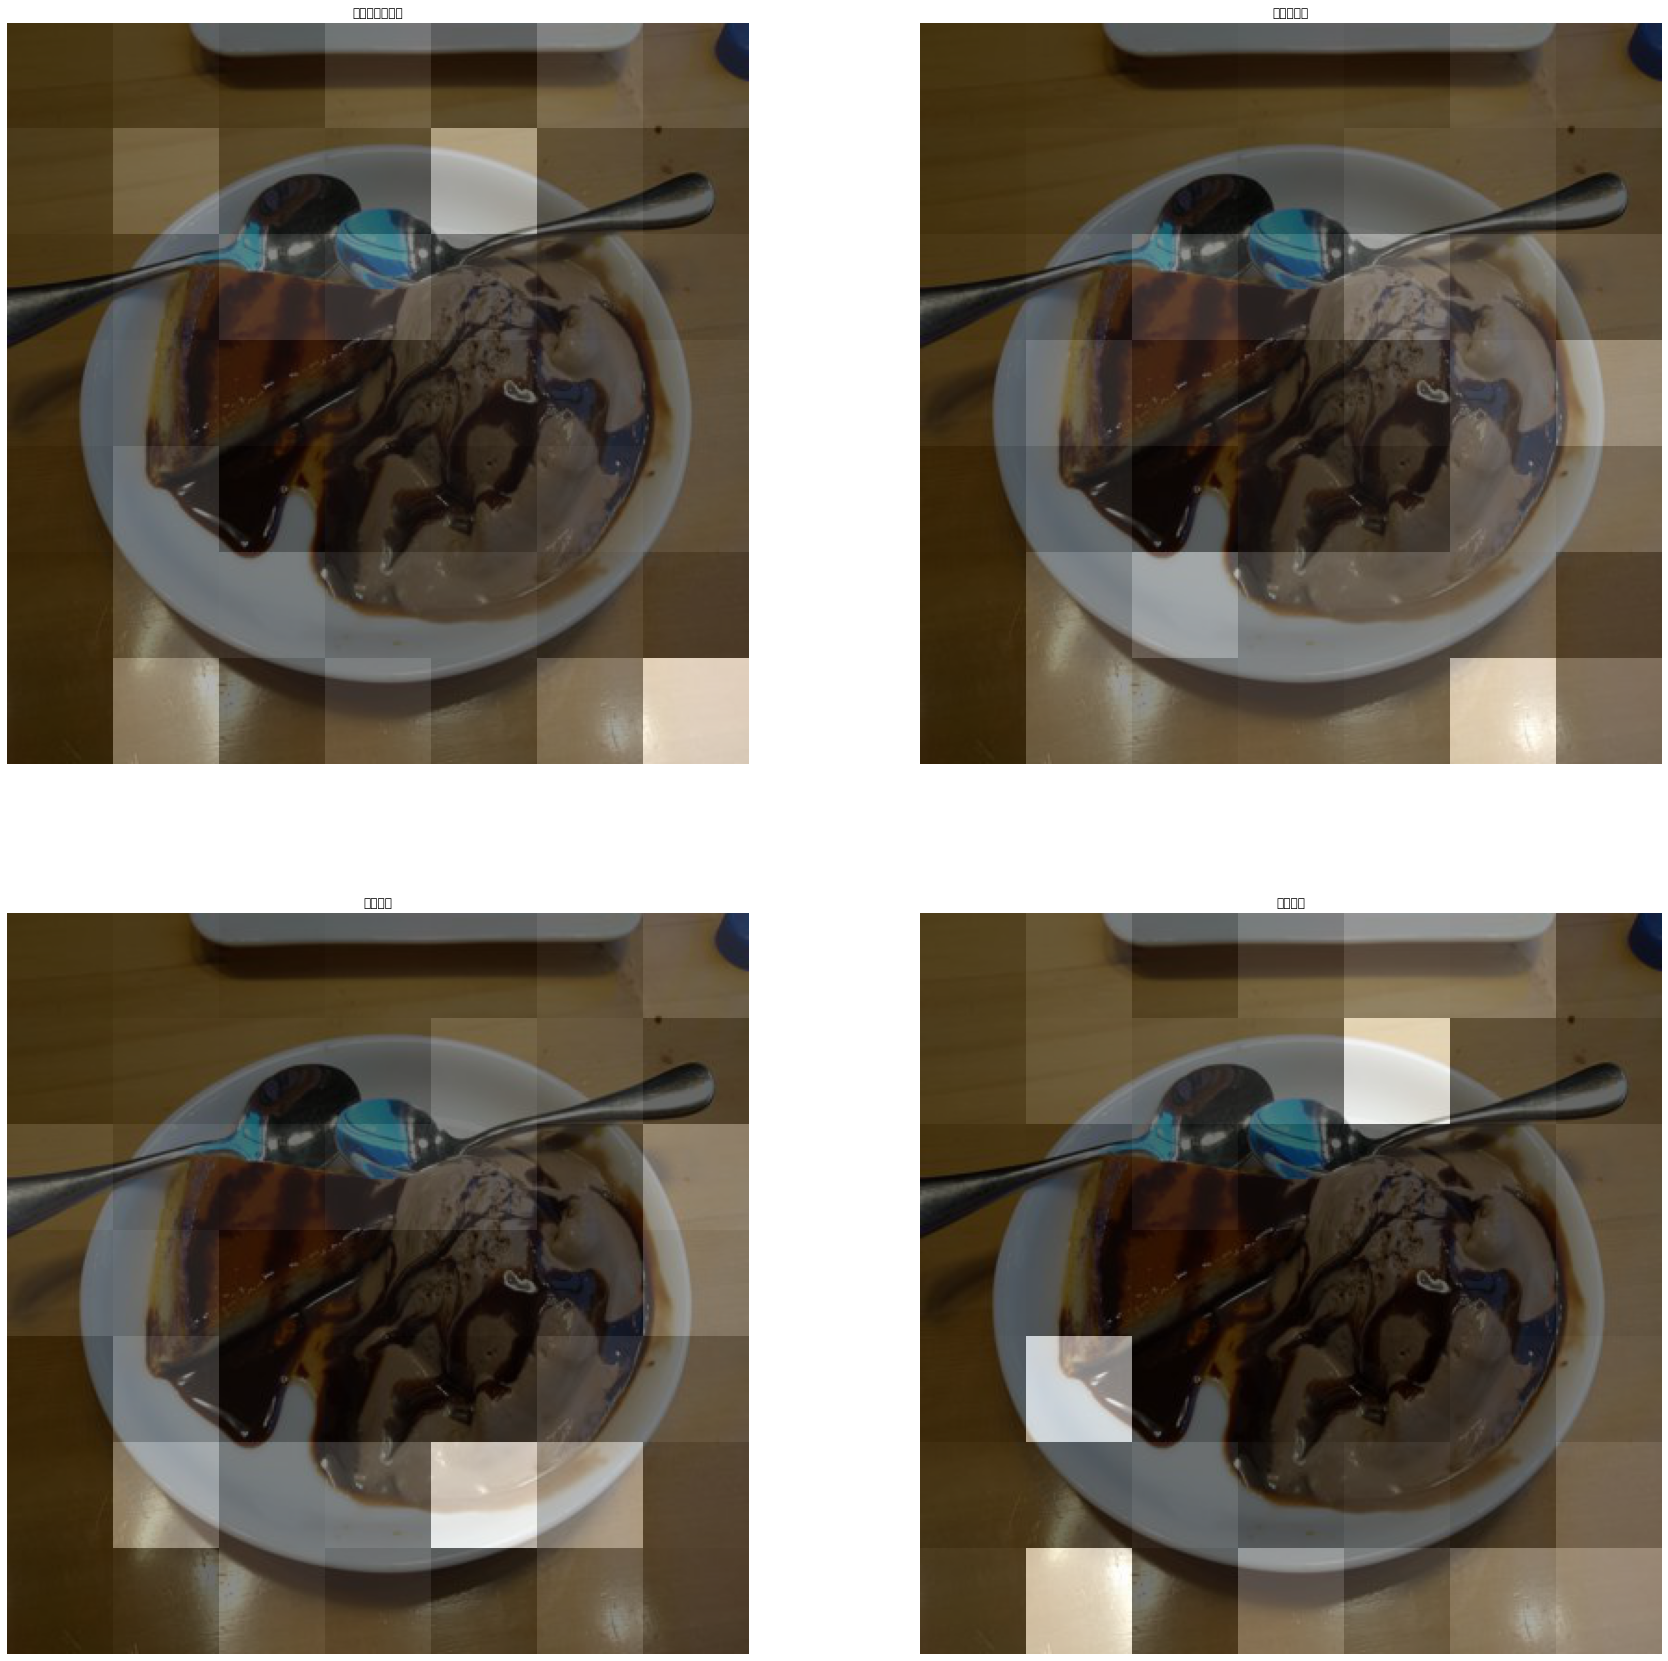

In [75]:
test_image = pred_caption_audio(len(path_test_shot1), True, weights = (0.5, 0.5, 0, 0))
Image.open(test_image)

In [ ]:
cap_test_data = caption_test.copy()
rid = np.random.randint(0, len(path_test))
test_image= path_test[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[rid] if i not in [0]])
result, attention_plot, pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()
smooth = SmoothingFunction().method4
bleu1 = sentence_bleu(reference, candidate, weights=(1.0, 0, 0, 0), smoothing_function=smooth)*100
bleu2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)*100
bleu3 = sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.37, 0), smoothing_function=smooth)*100
bleu4 = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)*100
print('BLEU-1: %f' % bleu1)
print('BLEU-2: %f' % bleu2)
print('BLEU-3: %f' % bleu3)
print('BLEU-4: %f' % bleu4)
print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attention_map(result, attention_plot, test_image)

In [76]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [77]:
from nltk.translate.meteor_score import meteor_score

In [ ]:
b1=[]
b2=[]
b3=[]
b4=[]
m_score = []

for rid in range(0,len(path_test)):
  test_image= path_test[rid]
  real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
  result, attention_plot, pred_test = evaluate(test_image)
  real_caption=filt_text(real_caption)      
  pred_caption=' '.join(result).rsplit(' ', 1)[0]
  real_appn = []
  real_appn.append(real_caption.split())
  reference = real_appn
  candidate = pred_caption.split()
  smooth = SmoothingFunction().method4
  bleu1 = sentence_bleu(reference, candidate, weights=(1.0, 0, 0, 0), smoothing_function=smooth)*100
  bleu2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)*100
  bleu3 = sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.37, 0), smoothing_function=smooth)*100
  bleu4 = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)*100
  b1.append(bleu1)
  b2.append(bleu2)
  b3.append(bleu3)
  b4.append(bleu4)
  score = meteor_score(reference,candidate)
  m_score.append(score)

In [ ]:
print('BLEU-1: %f' % np.mean(b1))
print('BLEU-2: %f' % np.mean(b2))
print('BLEU-3: %f' % np.mean(b3))
print('BLEU-4: %f' % np.mean(b4))

In [ ]:
print('Meteor Score of Bahdanau attention: %f' % np.mean(m_score))

# ZERO SHOT LEARNING

## Test with Bornon Dataset

In [ ]:
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

In [ ]:
import zipfile
exfile= '/content/drive/MyDrive/NLP dataset/Bornon/Bornon Images-20221222T175856Z-001.zip'
zip_ref = zipfile.ZipFile(exfile, 'r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
from os import listdir
## The location of the Flickr8K_ photos
image_dir = '/content/Bornon Images'
images = listdir(image_dir)

## The location of the caption file
descriptions_dir = '/content/drive/MyDrive/Thesis/Bornon/bornon_train_token.txt'
print("The number of jpg flies in Bornon: {}".format(len(images)))

In [ ]:
train_captions_bornon = load(open('/content/drive/MyDrive/NLP dataset/Bornon/bornon_captions.pkl', 'rb'))
img_name_vector_bornon = load(open('/content/drive/MyDrive/NLP dataset/Bornon/bornon_img_names.pkl', 'rb'))

In [ ]:
img_name_vector_bornon[:5]

## Tokenizer and Vocabulary (Bornon)

In [ ]:
import tensorflow as tf

In [78]:
bornon_train, bornon_test, bornon_cap_train, bornon_cap_test = train_test_split(img_name_vector_bornon, train_captions_bornon, test_size = 0.1, random_state = 42)

In [79]:
len(bornon_test)

2044

In [80]:
bornon_cap_test[:10]

['<start>    লাল শাড়ী পরা এক মহিলার ছবি দেখা যাচ্ছে   <end>',
 '<start>    গরু টানা লাঙ্গল দিয়ে ধানক্ষেত চাষ করা হচ্ছে   <end>',
 '<start>    সমুদ্রের নীল জল দেখা যাচ্ছে   <end>',
 '<start>    একটি পুকুরের ধারে দুটি গাছ আছে   <end>',
 '<start>    আমার বেলা যে যায় সাঁঝ বেলাতে তোমার সুরে সুরে সুর মেলাতে   <end>',
 '<start>    একটি সব্জির বাজার দেখা যাচ্ছে   <end>',
 '<start>    একটি বাদামি টিকটিকির পিছে সবুজ গাছ দেখা যাচ্ছে   <end>',
 '<start>    এক ধরনের পানিয় দেখা যাচ্ছে   <end>',
 '<start>    একজন বৃদ্ধ বসে নামাজ পড়ছে   <end>',
 '<start>    বড় বড় পাতা দেখা যাচ্ছে   <end>']

BLEU-1: 42.324086
BLEU-2: 11.330718
BLEU-3: 5.505162
BLEU-4: 4.188028
Real Caption: মাটির ওপর একটি বাটিতে ভাপা পিঠা রাখা
Prediction Caption: একটি স্টিলের বাটিতে খাবার রাখা আছে


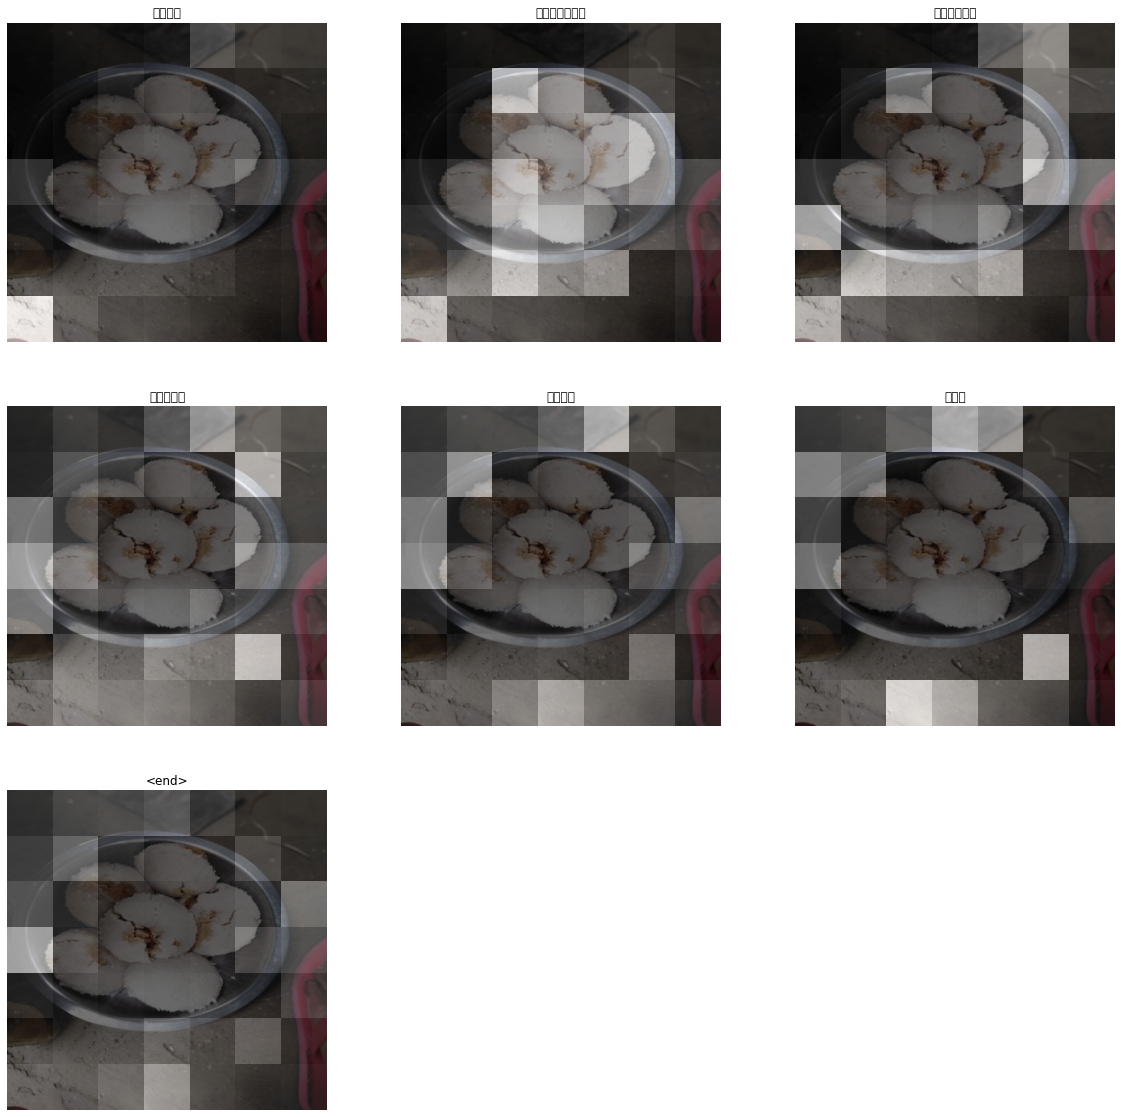

In [88]:
cap_test = bornon_cap_test.copy()
rid = np.random.randint(0, len(bornon_test))
test_image= bornon_test[rid]
real_caption = bornon_cap_test[rid]
result, attention_plot, pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()
smooth = SmoothingFunction().method4
bleu1 = sentence_bleu(reference, candidate, weights=(1.0, 0, 0, 0), smoothing_function=smooth)*100
bleu2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)*100
bleu3 = sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.37, 0), smoothing_function=smooth)*100
bleu4 = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)*100
print('BLEU-1: %f' % bleu1)
print('BLEU-2: %f' % bleu2)
print('BLEU-3: %f' % bleu3)
print('BLEU-4: %f' % bleu4)
print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attention_map(result, attention_plot, test_image)

In [82]:
b1_test=[]
b2_test=[]
b3_test=[]
b4_test=[]
m_test = []

for rid in range(0,len(bornon_cap_test)):
  test_image= bornon_test[rid]
  real_caption = bornon_cap_test[rid]
  result, attention_plot, pred_test = evaluate(test_image)
  real_caption=filt_text(real_caption)      
  pred_caption=' '.join(result).rsplit(' ', 1)[0]
  real_appn = []
  real_appn.append(real_caption.split())
  reference = real_appn
  candidate = pred_caption.split()
  smooth = SmoothingFunction().method4
  bleu1 = sentence_bleu(reference, candidate, weights=(1.0, 0, 0, 0), smoothing_function=smooth)*100
  bleu2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)*100
  bleu3 = sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.37, 0), smoothing_function=smooth)*100
  bleu4 = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)*100
  b1_test.append(bleu1)
  b2_test.append(bleu2)
  b3_test.append(bleu3)
  b4_test.append(bleu4)
  score = meteor_score(reference,candidate)
  m_test.append(score)

In [83]:
# Zero shot result
print('BLEU-1: %f' % np.mean(b1_test))
print('BLEU-2: %f' % np.mean(b2_test))
print('BLEU-3: %f' % np.mean(b3_test))
print('BLEU-4: %f' % np.mean(b4_test))
print('Meteor Score of zero shot test: %f' % np.mean(m_test))

BLEU-1: 19.766148
BLEU-2: 12.190464
BLEU-3: 7.440036
BLEU-4: 5.842413
Meteor Score of zero shot test: 0.181026
